In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, Subset
from torchsummary import summary
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold
from torchvision import transforms
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
import torch
torch.manual_seed(0)
import random
random.seed(0)

import warnings
warnings.filterwarnings("ignore")

## Explanation

### Preprocessing

Since the VIS-NIR images were so large that they couldn't be held in memory for training deep learning models, the images were split into 25x25 patches. Then PCA was performed on these patches to reduce the spectral dimension from 673 to 32 principal components.

I tested splitting the mites into different infestation levels, according to level 1: 1-15 motiles, level 2:15-70 motiles, level 3: 70+ motiles. This did not work well, with lots of confusion between infestation levels, so I pooled the mite groups together into one mite group, so there are three classes: control, mites, drought. Then the images are classified for each imaging day seperately.


### Model

A ResNet18 model, modified to take as input the PCA dim. red image patches instead of RGB images.

The model is trained on the patches, and the loss function takes into account how well it does on the patches. But in addition there is an image_wise classification where the voting for all the patches for each image is used to create one overall classification for the


### Results



In [4]:
class PrecomputedPatchDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path)
        self.patches = data["patches"]    # (N, C, ph, pw) where C=B or K
        self.labels  = data["labels"]    # (N,)
        # Backward compatible: if image_ids missing, make a dummy sequence
        self.image_ids = data["image_ids"] if "image_ids" in data else np.arange(len(self.labels), dtype=np.int32)


    def __len__(self): return len(self.labels)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.patches[idx]).float()   # (C, ph, pw)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        img_id = int(self.image_ids[idx])
        return x, y, img_id


In [5]:
# Using the dataset from imaging day 9 here
full_train_dataset9 = PrecomputedPatchDataset(npz_path="/content/drive/MyDrive/Master/deep_learning/pca_train_patches_day9_32.npz")
test_dataset9 = PrecomputedPatchDataset(npz_path="/content/drive/MyDrive/Master/deep_learning/pca_test_patches_day9_32.npz")


In [6]:
full_train_loader9 = DataLoader(full_train_dataset9, batch_size=64, shuffle=True)
test_loader9 = DataLoader(test_dataset9, batch_size=64, shuffle=False)

In [7]:
# code from: https://www.geeksforgeeks.org/deep-learning/resnet18-from-scratch-using-pytorch/


class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        self.conv1 = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(
            out_channels, out_channels,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)

        # shortcut / downsample
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(
                    in_channels, out_channels,
                    kernel_size=1, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += self.shortcut(identity)
        out = self.relu(out)
        return out


class ResNet18HSI(nn.Module):
    def __init__(self, num_bands=32, num_classes=3):
        """
        num_bands: number of spectral bands in the patch (your D=50)
        Input shape: (N, num_bands, 25, 25)
        """
        super().__init__()

        # first conv: from bands -> 64 feature maps
        self.conv1 = nn.Conv2d(
            num_bands, 64,
            kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)


        #self.maxpool = nn.MaxPool2d(2, 2)

        # current number of channels going into the first block
        self.in_channels = 64

        self.layer1 = self._make_layer(BasicBlock, 64,  2, stride=1)
        self.layer2 = self._make_layer(BasicBlock, 128, 2, stride=2)
        self.layer3 = self._make_layer(BasicBlock, 256, 2, stride=2)
        self.layer4 = self._make_layer(BasicBlock, 512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        # x: (N, num_bands, 25, 25)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        #out = self.maxpool(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)

        out = self.avgpool(out)             # (N, 512, 1, 1)
        out = torch.flatten(out, 1)         # (N, 512)
        out = self.dropout(out)
        out = self.fc(out)                  # (N, num_classes)
        return out


In [8]:
device = torch.device("cuda")
model = ResNet18HSI(num_classes=3, num_bands=32).to(device)
summary(model, (32, 25, 25),  device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 25, 25]          18,432
       BatchNorm2d-2           [-1, 64, 25, 25]             128
              ReLU-3           [-1, 64, 25, 25]               0
            Conv2d-4           [-1, 64, 25, 25]          36,864
       BatchNorm2d-5           [-1, 64, 25, 25]             128
              ReLU-6           [-1, 64, 25, 25]               0
            Conv2d-7           [-1, 64, 25, 25]          36,864
       BatchNorm2d-8           [-1, 64, 25, 25]             128
              ReLU-9           [-1, 64, 25, 25]               0
       BasicBlock-10           [-1, 64, 25, 25]               0
           Conv2d-11           [-1, 64, 25, 25]          36,864
      BatchNorm2d-12           [-1, 64, 25, 25]             128
             ReLU-13           [-1, 64, 25, 25]               0
           Conv2d-14           [-1, 64,

In [9]:
# Function for evaluating the image-wise accuracy of the model
@torch.no_grad()
def evaluate_image_wise(model, val_loader, device, print_report=True):
    model.eval()
    img_to_preds = defaultdict(list)
    img_to_label = {}

    for x, y, img_id in val_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)               # shape (N, num_classes)
        preds = logits.argmax(1).cpu().tolist()

        for p, t, i in zip(preds, y.cpu().tolist(), img_id.tolist()):
            img_to_preds[i].append(p)
            img_to_label[i] = t

    y_true, y_pred = [], []
    for i, preds in img_to_preds.items():
        maj = Counter(preds).most_common(1)[0][0]
        y_pred.append(maj)
        y_true.append(img_to_label[i])

    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    if print_report:
        print(f"Image-wise  Acc: {acc:.4f} | F1-macro: {f1_macro:.4f} | F1-weighted: {f1_weighted:.4f}")

    return acc, f1_macro, (y_true, y_pred)


In [10]:
# Function for making Stratified K-folds which ensures the patches from each image all end up in either train or validation set (so there is no data leakage)
def make_image_level_folds(dataset, n_splits=5, shuffle=True, random_state=0):
    """
    dataset: an instance of PrecomputedPatchDataset
    returns: list of (train_patch_indices, val_patch_indices) for each fold
    """
    image_ids = dataset.image_ids        # (N,)
    labels    = dataset.labels           # (N,)

    # Map: img_id -> list of patch indices
    img_to_indices = defaultdict(list)
    for idx, img in enumerate(image_ids):
        img_to_indices[int(img)].append(idx)

    # One label per image (assumes all patches of an image share label)
    img_ids_unique = sorted(img_to_indices.keys())
    img_labels = []
    for img in img_ids_unique:
        first_patch_idx = img_to_indices[img][0]
        img_labels.append(labels[first_patch_idx])
    img_labels = np.array(img_labels)

    # Stratified K-Fold on images
    skf = StratifiedKFold(
        n_splits=n_splits,
        shuffle=shuffle,
        random_state=random_state
    )

    folds = []
    img_ids_unique = np.array(img_ids_unique)

    for train_img_idx, val_img_idx in skf.split(img_ids_unique, img_labels):
        train_img_ids = img_ids_unique[train_img_idx]
        val_img_ids   = img_ids_unique[val_img_idx]

        # Expand image-level splits back to patch indices
        train_patch_indices = []
        val_patch_indices   = []

        for img in train_img_ids:
            train_patch_indices.extend(img_to_indices[int(img)])
        for img in val_img_ids:
            val_patch_indices.extend(img_to_indices[int(img)])

        folds.append((train_patch_indices, val_patch_indices))

    return folds


In [11]:
# Function for evaluating patch-wise accuracy.
@torch.no_grad()
def evaluate_patchwise(model, loader, device):
    model.eval()
    all_true, all_pred = [], []

    for x, y, _ in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        preds = out.argmax(1)

        all_true.extend(y.cpu().tolist())
        all_pred.extend(preds.cpu().tolist())

    acc = accuracy_score(all_true, all_pred)
    f1_macro = f1_score(all_true, all_pred, average="macro")
    f1_weighted = f1_score(all_true, all_pred, average="weighted")
    return acc, f1_macro, f1_weighted



In [12]:
# Training and Validation loops on a five-fold validation.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Since we have an imbalanced dataset, we use class weights to account for this imbalance when training.
class_counts = []
for x, y, _ in full_train_loader9:
    y = y.cpu().tolist()
    class_counts.extend(y)

labels, counts = np.unique(class_counts, return_counts=True)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * len(class_weights)
print("Class counts:", counts)
print("Class weights:", class_weights)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

num_classes = 3
num_epochs = 50
n_splits = 5

# ---- Build image-level folds (train_dataset is your PrecomputedPatchDataset) ----
folds = make_image_level_folds(full_train_dataset9, n_splits=n_splits)

# ---- Storage for metrics: [fold][epoch] ----
val_f1_patchwise_folds = [[] for _ in range(n_splits)]
val_f1_imagewise_folds = [[] for _ in range(n_splits)]

train_loss_list = [[] for _ in range(n_splits)]
val_loss_list = [[] for _ in range(n_splits)]



for fold_idx, (train_idx, val_idx) in enumerate(folds):
    print(f"Fold {fold_idx}: train patches = {len(train_idx)}, val patches = {len(val_idx)}")

    # 1) Subsets for this fold
    train_subset = Subset(full_train_dataset9, train_idx)
    val_subset   = Subset(full_train_dataset9, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader   = DataLoader(val_subset,   batch_size=32, shuffle=False)

    # 2) New model/optimizer per fold
    model = ResNet18HSI(num_classes=num_classes, num_bands=32).to(device)
    criterion = torch.nn.CrossEntropyLoss(class_weights_tensor, label_smoothing=0.05)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

    for epoch in range(num_epochs):
        # -------------------- TRAIN --------------------
        model.train()
        train_loss_sum = 0.0
        train_total = 0
        train_true = []
        train_pred = []

        for x, y, ids in train_loader:
            x, y = x.to(device), y.to(device)

            optimizer.zero_grad(set_to_none=True)

            if device.type == "cuda":
                with torch.cuda.amp.autocast():
                    out = model(x)
                    loss = criterion(out, y)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                out = model(x)
                loss = criterion(out, y)
                loss.backward()
                optimizer.step()

            train_loss_sum += loss.item() * x.size(0)
            train_total += y.size(0)

            preds = out.argmax(1)
            train_true.extend(y.cpu().tolist())
            train_pred.extend(preds.cpu().tolist())

        train_loss = train_loss_sum / train_total
        train_acc = accuracy_score(train_true, train_pred)
        train_f1 = f1_score(train_true, train_pred, average="macro")

        # -------------------- VALIDATION (PATCH-WISE) --------------------
        model.eval()
        val_loss_sum = 0.0
        val_total = 0
        val_true = []
        val_pred = []

        with torch.no_grad():
            for x, y, _ in val_loader:   # <-- use val_loader, not test_loader
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                val_loss_sum += loss.item() * x.size(0)
                val_total += y.size(0)

                preds = out.argmax(1)
                val_true.extend(y.cpu().tolist())
                val_pred.extend(preds.cpu().tolist())

        val_loss = val_loss_sum / val_total
        val_acc = accuracy_score(val_true, val_pred)
        val_f1_patch = f1_score(val_true, val_pred, average="macro")

        # -------------------- VALIDATION (IMAGE-WISE) --------------------
        # call your probability-averaging eval on the *same* val_loader
        val_img_acc, val_f1_img_macro, (y_true_img, y_pred_img) = \
            evaluate_image_wise(model, val_loader, device, print_report=False)

        # Store per-epoch F1 for this fold
        val_f1_patchwise_folds[fold_idx].append(val_f1_patch)
        val_f1_imagewise_folds[fold_idx].append(val_f1_img_macro)

        train_loss_list[fold_idx].append(train_loss)
        val_loss_list[fold_idx].append(val_loss)


        # Optional: print
        """
        print(
            f"[Fold {fold_idx} | Epoch {epoch+1}/{num_epochs}]\n"
            f"  Train: loss={train_loss:.4f}, acc={train_acc:.3f}, f1={train_f1:.3f}\n"
            f"  Val (patch): loss={val_loss:.4f}, acc={val_acc:.3f}, f1={val_f1_patch:.3f}\n"
            f"  Val (image): acc={val_img_acc:.3f}, f1={val_f1_img_macro:.3f}\n"
        )
        """

# After all folds:
# val_f1_patchwise_folds and val_f1_imagewise_folds now contain all your histories.
# Example: average best image-wise F1 per fold:
best_img_f1_per_fold = [max(hist) for hist in val_f1_imagewise_folds]
print("Best image-wise F1 per fold:", best_img_f1_per_fold)
print("Mean best image-wise F1:", np.mean(best_img_f1_per_fold))


Class counts: [1906  933 5155]
Class weights: [0.87909239 1.79587364 0.32503397]
Fold 0: train patches = 6722, val patches = 1272
Fold 1: train patches = 6284, val patches = 1710
Fold 2: train patches = 6247, val patches = 1747
Fold 3: train patches = 6485, val patches = 1509
Fold 4: train patches = 6238, val patches = 1756
Best image-wise F1 per fold: [0.8585858585858586, 0.6363636363636364, 1.0, 0.75, 0.6]
Mean best image-wise F1: 0.768989898989899


In [13]:
# Convert list-of-lists -> (n_folds, num_epochs) array
val_f1_img_arr = np.array(val_f1_imagewise_folds)   # shape: (n_folds, num_epochs)

# Mean and std across folds for each epoch
mean_f1_per_epoch = val_f1_img_arr.mean(axis=0)     # (num_epochs,)
std_f1_per_epoch  = val_f1_img_arr.std(axis=0)      # (num_epochs,)

best_epoch_idx = np.argmax(mean_f1_per_epoch)   # 0-based index
best_epoch = best_epoch_idx + 1                 # if your training epochs are 1..num_epochs
print(f"Best epoch overall (1-based): {best_epoch}")
print(f"Mean F1 at best epoch: {mean_f1_per_epoch[best_epoch_idx]:.4f} "
      f"+/- {std_f1_per_epoch[best_epoch_idx]:.4f}")


Best epoch overall (1-based): 3
Mean F1 at best epoch: 0.6708 +/- 0.1274


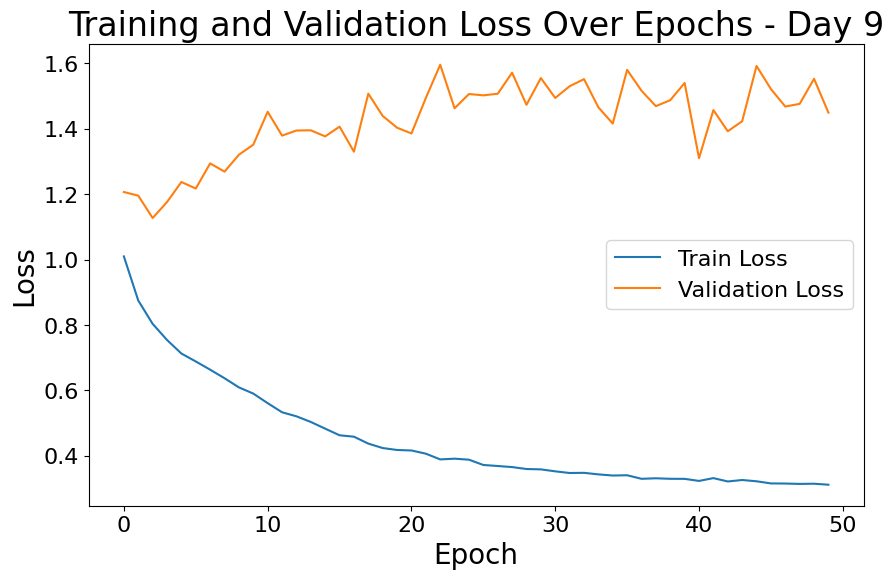

In [14]:
# Plotting the training and validation loss
mean_train_loss = np.mean(train_loss_list, axis=0)
mean_val_loss = np.mean(val_loss_list, axis=0)
plt.figure(figsize=(10, 6))
plt.plot(range(50), mean_train_loss, label='Train Loss')
plt.plot(range(50), mean_val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs - Day 9', fontsize=24)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
#plt.savefig("/content/drive/MyDrive/Master/data/plots/cnn_loss_day_9.png", dpi=400)



In [28]:
#
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Compute class weights from all training patches
class_counts = []
for x, y, _ in full_train_loader9:
    class_counts.extend(y.cpu().tolist())

labels, counts = np.unique(class_counts, return_counts=True)
class_weights = 1.0 / counts
class_weights = class_weights / class_weights.sum() * len(class_weights)

print("Class counts:", counts)
print("Class weights:", class_weights)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
num_classes = 3
num_epochs = 19

model = ResNet18HSI(num_classes=num_classes, num_bands=32).to(device)

criterion = torch.nn.CrossEntropyLoss(
    weight=class_weights_tensor,
    label_smoothing=0.05
)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))


Class counts: [1906  933 5155]
Class weights: [0.87909239 1.79587364 0.32503397]


### Training model on full training dataset

In [29]:
train_loss_list = []
test_loss_list = []
for epoch in range(num_epochs):
    model.train()
    train_loss_sum = 0.0
    train_total = 0
    train_true = []
    train_pred = []

    for x, y, ids in full_train_loader9:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)

        if device.type == "cuda":
            with torch.cuda.amp.autocast():
                out = model(x)
                loss = criterion(out, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

        train_loss_sum += loss.item() * x.size(0)
        train_total += y.size(0)

        preds = out.argmax(1)
        train_true.extend(y.cpu().tolist())
        train_pred.extend(preds.cpu().tolist())

    train_loss = train_loss_sum / train_total
    train_acc = accuracy_score(train_true, train_pred)
    train_f1 = f1_score(train_true, train_pred, average="macro")


    model.eval()
    val_loss_sum = 0.0
    val_total = 0
    val_true = []
    val_pred = []

    with torch.no_grad():
        for x, y, _ in test_loader9:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)

            val_loss_sum += loss.item() * x.size(0)
            val_total += y.size(0)

            preds = out.argmax(1)
            val_true.extend(y.cpu().tolist())
            val_pred.extend(preds.cpu().tolist())

    test_loss = val_loss_sum / val_total


    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)



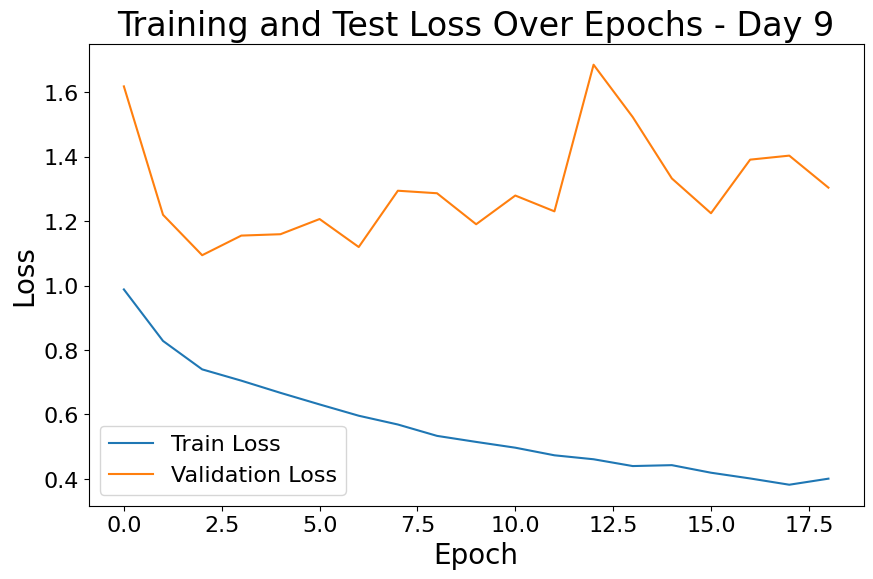

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), train_loss_list, label='Train Loss')
plt.plot(range(num_epochs), test_loss_list, label='Validation Loss')
plt.title('Training and Test Loss Over Epochs - Day 9', fontsize=24)
plt.xlabel('Epoch', fontsize=20)
plt.ylabel('Loss', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16)
#plt.savefig("/content/drive/MyDrive/Master/data/plots/cnn_loss_day_9.png", dpi=400)



In [31]:
test_patch_acc, test_patch_f1_macro, test_patch_f1_weighted = \
    evaluate_patchwise(model, test_loader9, device)

print(f"[TEST patch-wise] Acc={test_patch_acc:.3f}, "
      f"F1-macro={test_patch_f1_macro:.3f}, F1-weighted={test_patch_f1_weighted:.3f}")

test_img_acc, test_img_f1_macro, (y_true_img, y_pred_img) = \
    evaluate_image_wise(model, test_loader9, device, print_report=False)

print(f"[TEST image-wise] Acc={test_img_acc:.3f}, F1-macro={test_img_f1_macro:.3f}")

[TEST patch-wise] Acc=0.651, F1-macro=0.580, F1-weighted=0.652
[TEST image-wise] Acc=0.800, F1-macro=0.767


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.text import Text
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import re
def plot_confusion_matrices_per_day(y_true, y_pred, day=None, class_names=None):
    """
    Plots one confusion matrix per unique day.

    y_true:  (N,) list/array of true labels (image-wise)
    y_pred:  (N,) list/array of predicted labels (image-wise)
    day_ids: (N,) list/array indicating day for each image
    class_names: optional list of names for classes (e.g. ["Control","Drought","Mites"])
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(5, 4))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap="Blues", values_format="d")
    for text in disp.ax_.get_children():
      if isinstance(text, Text):
        if re.fullmatch(r"\d+", text.get_text()):  # match integers
            text.set_fontsize(14)
    disp.ax_.tick_params(axis='y', labelsize=14)
    disp.ax_.tick_params(axis='x', labelsize=14, rotation=45)
    # Change axis labels
    disp.ax_.set_xlabel("Predicted label", fontsize=18)
    disp.ax_.set_ylabel("True label", fontsize=18)
    plt.title(f"ResNet18 Confusion Matrix – Day {day}", fontsize=20)
    plt.savefig(f"/content/drive/MyDrive/Master/data/plots/confusion_matrix_day_cnn_{day}.png", dpi=400)
    plt.tight_layout()
    plt.show()


<Figure size 500x400 with 0 Axes>

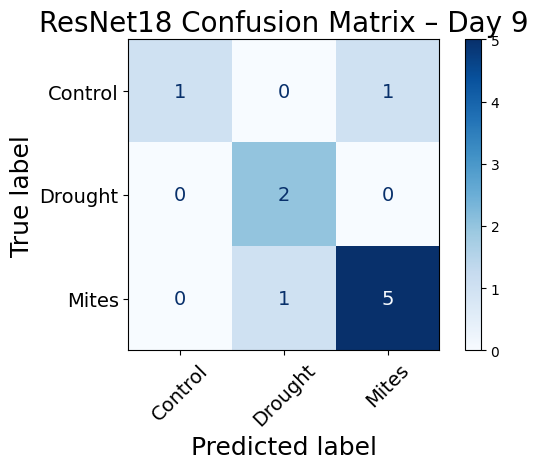

In [33]:
class_names = ["Control", "Drought", "Mites"]

plot_confusion_matrices_per_day(y_true_img, y_pred_img, 9, class_names)
